<a href="https://colab.research.google.com/github/YeonJeong-Claire/Project/blob/main/Garbage%20Classification%20(Kaggle)/garbage_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. 구글 드라이브 연동 및 압축 풀기**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/') 

Mounted at /content/gdrive/


In [ ]:
# 현재 directory 확인
import os
os.getcwd()

'/content'

In [ ]:
# 새로운 directory 형성
#!mkdir /content/gdrive/MyDrive/garbage_data

In [ ]:
# 생성한 directory에 압축 풀기
#!unzip -o /content/gdrive/MyDrive/garbage_archive.zip -d /content/gdrive/MyDrive/garbage_data

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/gdrive/MyDrive/garbage_data/garbage_classification/paper/paper381.jpg  
  inflating: /content/gdrive/MyDrive/garbage_data/garbage_classification/paper/paper382.jpg  
  inflating: /content/gdrive/MyDrive/garbage_data/garbage_classification/paper/paper383.jpg  
  inflating: /content/gdrive/MyDrive/garbage_data/garbage_classification/paper/paper384.jpg  
  inflating: /content/gdrive/MyDrive/garbage_data/garbage_classification/paper/paper385.jpg  
  inflating: /content/gdrive/MyDrive/garbage_data/garbage_classification/paper/paper386.jpg  
  inflating: /content/gdrive/MyDrive/garbage_data/garbage_classification/paper/paper387.jpg  
  inflating: /content/gdrive/MyDrive/garbage_data/garbage_classification/paper/paper388.jpg  
  inflating: /content/gdrive/MyDrive/garbage_data/garbage_classification/paper/paper389.jpg  
  inflating: /content/gdrive/MyDrive/garbage_data/garbage_classification/paper/paper39.jpg  
  inflating: /content/gdr

# **2. TensorFlow 및 기타 라이브러리 import**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras import optimizers
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# **3. 데이터세트 생성**

In [ ]:
# 기본 데이터 directory 설정
dir = '/content/gdrive/MyDrive/garbage_data/garbage_classification' 

In [ ]:
image_size = (150, 150)  # 학습 속도 빠르게 하기 위함 - 이미지 사이즈 비율이 1:1일 때가 가장 성능 좋음
batch_size = 32 

## **데이터 분할(학습용 데이터 / 검증용 데이터)**

모델을 개발할 떄 검증 분할을 사용하는 것이 좋음. 훈련에 이미지 80%를 사용하고 검증에 20% 사용

### **학습용 데이터**

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    dir,
    validation_split = 0.2,
    subset = 'training',
    image_size = image_size,
    seed = 123,
    batch_size = batch_size
)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.


### **검증용 데이터**

In [ ]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    dir,
    validation_split = 0.2,
    subset = 'validation',
    image_size = image_size,
    seed = 123,
    batch_size = batch_size
)

Found 15515 files belonging to 12 classes.
Using 3103 files for validation.


### **클래스 레이블 확인**

In [ ]:
class_label = train_data.class_names
print(class_label)

['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


## **학습용 데이터 시각화**

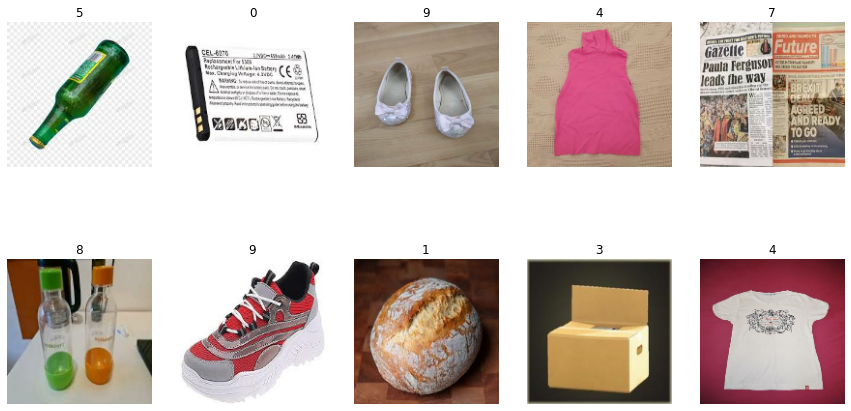

In [ ]:
plt.figure(figsize = (15,8))
for images,label in train_data.take(1):  # .take(1) : batch를 1번 불러온다.
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))  
        plt.title(int(label[i]))
        plt.axis('off')

## **검증용 데이터 시각화**

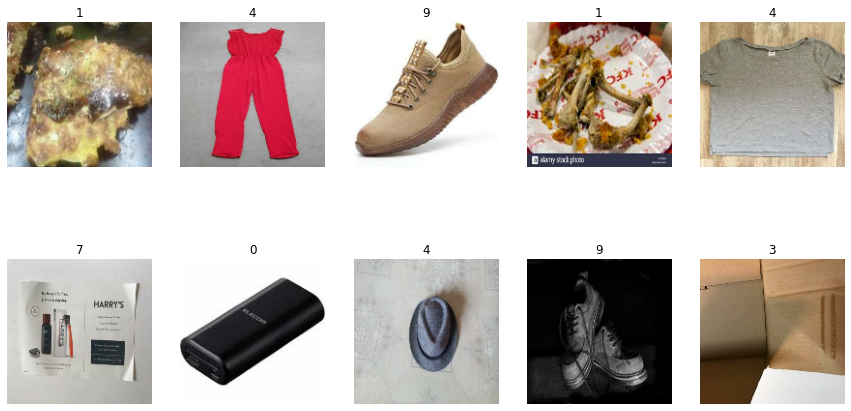

In [ ]:
plt.figure(figsize = (15,8))
for images,label in val_data.take(1):  # .take(1) : batch를 1번 불러온다.
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))  
        plt.title(int(label[i]))
        plt.axis('off')

In [ ]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


image_batch는 (32, 150, 150, 3) 형태의 텐서로 150 X 150 X 3 형상의 32개 이미지 묶음으로 구성됨을 의미.

label_batch는 형상 (32, )의 텐서로 32개 이미지에 해당하는 레이블 의미.

## **성능을 높이도록 데이터세트 구성**

버퍼링된 프리페치를 사용해 I/O를 차단하지 않고 디스크에서 데이터를 생성할 수 있도록 함.

* dataset.cache() : 첫 epoch동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지 -> 모델을 훈련하는 동안 데이터세트가 병목 상태(전체 시스템의 성능이나 용량이 하나의 구성 요소로 인해 제한을 받는 현상)가 되지 않음

* dataset.prefetch() : 훈련 중에 데이터 전처리 및 모델 실행과 겹침

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_data.cache().prefetch(buffer_size=AUTOTUNE)

## **데이터 표준화**

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

RGB 채널 값은 [0, 255] 범위에 존재. 

Rescalling 레이어를 사용해 값이 [0, 1]에 있도록 표준화

In [ ]:
normalized_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99673206


In [ ]:
preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255)

# **4. 모델링**

## **콜백 함수(tf.keras.callbacks.EarlyStopping)**
: 모델을 더 이상 학습하지 못할 경우, 학습 도중 미리 학습 종료시키는 콜백함수

* monitor : 기준이 되는 값(val_loss는 val_loss가 더 이상 감소되지 않을 경우 콜백함수 적용)
* patience : Training이 진행됨에도 더 이상 monitor되는 값의 개선이 없을 경우 몇 번의 epoch를 진행할지 정하는 값
* verbose : 콜백함수 적용될 때 화면에 적용되었다고 나타남(1인 경우)
* restore_best_weights : True일 경우 training이 끝난 후 model의 weight를 monitor하고 있던 값이 가장 좋았을 때의 weights 로 복원

In [ ]:
call_back = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [ ]:
num_classes = 12
img_height = 150
img_width = 150

## **모델 생성**

In [ ]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### **모델 컴파일**

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### **모델 훈련**

In [ ]:
epochs = 10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=call_back
)

Epoch 1/8
388/388 [==============================] - 9s 21ms/step - loss: 1.6849 - accuracy: 0.4626 - val_loss: 1.0336 - val_accuracy: 0.6542
Epoch 2/8
388/388 [==============================] - 8s 21ms/step - loss: 0.9156 - accuracy: 0.6956 - val_loss: 0.8608 - val_accuracy: 0.7238
Epoch 3/8
388/388 [==============================] - 8s 21ms/step - loss: 0.6486 - accuracy: 0.7932 - val_loss: 0.7845 - val_accuracy: 0.7544
Epoch 4/8
388/388 [==============================] - 8s 21ms/step - loss: 0.4796 - accuracy: 0.8435 - val_loss: 0.8613 - val_accuracy: 0.7515
Epoch 5/8
388/388 [==============================] - 8s 21ms/step - loss: 0.2972 - accuracy: 0.9045 - val_loss: 0.9124 - val_accuracy: 0.7567
Epoch 6/8
388/388 [==============================] - 8s 21ms/step - loss: 0.1894 - accuracy: 0.9405 - val_loss: 1.1039 - val_accuracy: 0.7490
Epoch 7/8
388/388 [==============================] - 8s 21ms/step - loss: 0.1445 - accuracy: 0.9540 - val_loss: 1.1807 - val_accuracy: 0.7509
Epoch 

### **모델 요약**

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_44 (ModuleWra (None, 150, 150, 3)       0         
_________________________________________________________________
module_wrapper_45 (ModuleWra (None, 150, 150, 16)      448       
_________________________________________________________________
module_wrapper_46 (ModuleWra (None, 75, 75, 16)        0         
_________________________________________________________________
module_wrapper_47 (ModuleWra (None, 75, 75, 32)        4640      
_________________________________________________________________
module_wrapper_48 (ModuleWra (None, 37, 37, 32)        0         
_________________________________________________________________
module_wrapper_49 (ModuleWra (None, 37, 37, 64)        18496     
_________________________________________________________________
module_wrapper_50 (ModuleWra (None, 18, 18, 64)       

### **훈련 결과 시각화**

훈련 및 검증 세트에 대한 손실과 정확성 플롯 생성

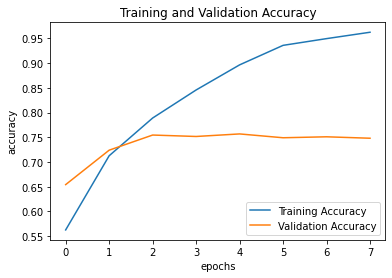

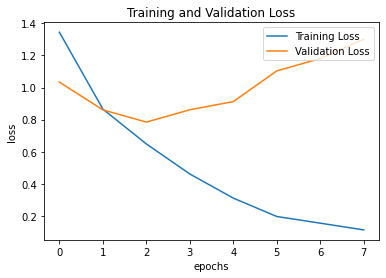

In [ ]:
epochs = 8
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# figure 1
plt.figure()
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')

# figure 2
plt.figure()
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.show()

과대적합 가능성 존재.

## **과대적합 해결 모델**

### **이미지 증강**

In [ ]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal'), #"horizontal"은 왼쪽에서 오른쪽으로 뒤집는 것 | "vertical"은 위에서 아래로 뒤집는 것
    layers.experimental.preprocessing.RandomRotation(0.1) # 각 이미지를 무작위로 회전 -> 여기서는 factor값이 (-0.1,0.1) 즉, 시계반대or시계방향으로 [-+ 10% * 2pi]
])

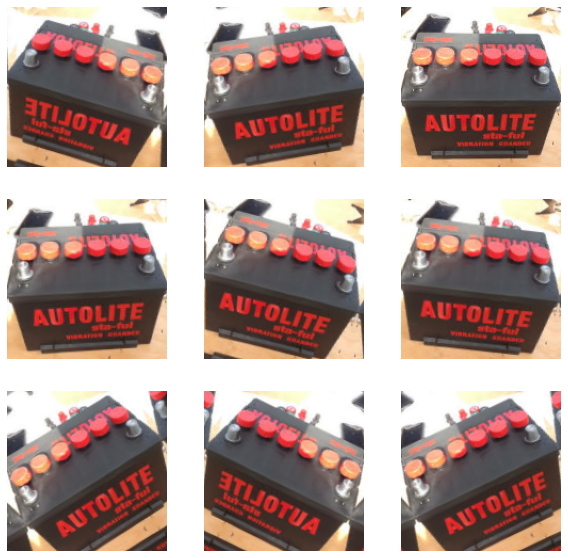

In [ ]:
plt.figure(figsize=(10,10))

for images, _ in train_ds.take(1): 
    for i in range(9):
        aug_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(aug_images[0].numpy().astype('uint8'))
        plt.axis('off')

### **드롭아웃**

드롭아웃을 적용하면 훈련 프로세스 중에 레이어에서 여러 출력 단위가 무작위로 드롭아웃(활성화를 0으로 설정). 

드롭아웃은 0.1, 0.2, 0.4 등의 형식으로 소수를 입력 값으로 사용. 

-> 적용된 레이어에서 출력 단위의 10%, 20% 또는 40%를 임의로 제거하는 것 의미

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### **모델 컴파일 및 훈련**

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 15

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
388/388 [==============================] - 2479s 1s/step - loss: 1.7891 - accuracy: 0.4188 - val_loss: 1.1891 - val_accuracy: 0.6162
Epoch 2/15
388/388 [==============================] - 9s 22ms/step - loss: 1.1283 - accuracy: 0.6284 - val_loss: 1.0448 - val_accuracy: 0.6526
Epoch 3/15
388/388 [==============================] - 9s 22ms/step - loss: 0.9321 - accuracy: 0.6883 - val_loss: 0.9228 - val_accuracy: 0.7038
Epoch 4/15
388/388 [==============================] - 9s 22ms/step - loss: 0.8463 - accuracy: 0.7192 - val_loss: 0.9226 - val_accuracy: 0.6971
Epoch 5/15
388/388 [==============================] - 9s 22ms/step - loss: 0.8056 - accuracy: 0.7300 - val_loss: 0.8554 - val_accuracy: 0.7270
Epoch 6/15
388/388 [==============================] - 9s 22ms/step - loss: 0.7240 - accuracy: 0.7562 - val_loss: 0.8476 - val_accuracy: 0.7403
Epoch 7/15
388/388 [==============================] - 9s 22ms/step - loss: 0.7092 - accuracy: 0.7622 - val_loss: 0.8766 - val_accuracy: 0.746

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 150, 150, 3)       0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 150, 150, 3)       0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 150, 150, 16)      448       
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 75, 75, 16)        0         
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 75, 75, 32)        4640      
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 37, 37, 32)        0         
_________________________________________________________________
module_wrapper_6 (ModuleWrap (None, 37, 37, 64)        1

### **훈련 결과 시각화**

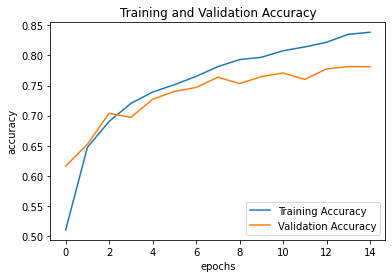

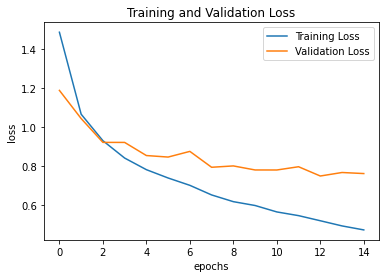

In [ ]:
epochs = 15

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# figure 1
plt.figure()
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')

# figure 2
plt.figure()
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.show()

# **5. 새로운 데이터로 분류**

In [ ]:
from PIL import Image
import urllib.request

**이미지 1**

24576/18181 [========================================] - 0s 0us/step
이미지:


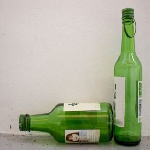

In [ ]:
url = 'https://ifh.cc/g/8oFikv.jpg'
path = tf.keras.utils.get_file('img1', origin=url)
img1 = keras.preprocessing.image.load_img(
    path, target_size=(img_height, img_width)
)

img_array1 = keras.preprocessing.image.img_to_array(img1)
img_array1 = tf.expand_dims(img_array1, 0)
print('이미지:')
img1

In [ ]:
predictions = model.predict(img_array1)
score = tf.nn.softmax(predictions[0])

print('분류 결과 : ', class_label[np.argmax(score)])
print('정확성 : {:.2f}%'.format(100 * np.max(score)))

분류 결과 :  green-glass
정확성 : 93.39%


**이미지 2**

24576/17184 [==========================================] - 0s 0us/step
이미지:


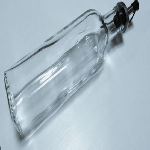

In [ ]:
url = 'https://ifh.cc/g/MO83zN.jpg'
path = tf.keras.utils.get_file('img2', origin=url)
img2 = keras.preprocessing.image.load_img(
    path, target_size=(img_height, img_width)
)

img_array2 = keras.preprocessing.image.img_to_array(img2)
img_array2 = tf.expand_dims(img_array2, 0)

print('이미지:')
img2

In [ ]:
predictions = model.predict(img_array2)
score = tf.nn.softmax(predictions[0])

print('분류 결과 : ', class_label[np.argmax(score)])
print('정확성 : {:.2f}%'.format(100 * np.max(score)))

분류 결과 :  metal
정확성 : 31.65%


**이미지 3**

49152/43199 [==================================] - 0s 3us/step
이미지: 


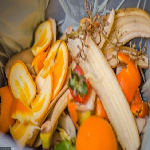

In [ ]:
url = 'https://ifh.cc/g/bDstWl.jpg'
path = tf.keras.utils.get_file('img4', origin=url)
  
img4 = keras.preprocessing.image.load_img(
    path, target_size=(img_height, img_width)
)

img_array4 = keras.preprocessing.image.img_to_array(img4)
img_array4 = tf.expand_dims(img_array4, 0)

print('이미지: ')
img4

In [ ]:
predictions = model.predict(img_array4)
score = tf.nn.softmax(predictions[0])

print('분류 결과 : ', class_label[np.argmax(score)])
print('정확성 : {:.2f}%'.format(100 * np.max(score)))

분류 결과 :  biological
정확성 : 96.62%


**이미지 4**

이미지: 


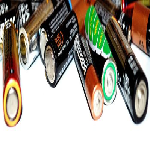

In [ ]:
url = 'https://ifh.cc/g/rNCi5H.jpg'
path = tf.keras.utils.get_file('img6', origin=url)

img6 = keras.preprocessing.image.load_img(
    path, target_size=(img_height, img_width)
)

img_array6 = keras.preprocessing.image.img_to_array(img6)
img_array6 = tf.expand_dims(img_array6, 0)

print('이미지: ')
img6

In [ ]:
predictions = model.predict(img_array6)
score = tf.nn.softmax(predictions[0])

print('분류 결과 : ', class_label[np.argmax(score)])
print('정확성 : {:.2f}%'.format(100 * np.max(score)))

분류 결과 :  battery
정확성 : 98.12%
